In [208]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import random

In [200]:
env = gym.make("Blackjack-v1", natural=False, sab=True)
state, info = env.reset()
print("Start state:", state)

Start state: (8, 10, 0)


In [201]:
print(f"Observation space dimensions:  {env.observation_space.shape}")
print(f"Number of possible actions: {env.action_space.n}")

Q = np.zeros((32, 11, 2, 2))    #player_sum, dealer_card, usable_ace, action
Q.shape

Observation space dimensions:  None
Number of possible actions: 2


(32, 11, 2, 2)

In [202]:
def update_explore_rate(episode, MIN_EXPLORE_RATE):
    decay = 0.001
    return max(MIN_EXPLORE_RATE, np.exp(-decay*episode))


def update_learning_rate(episode, MIN_LEARNING_RATE):
    decay = 0.01
    return max(MIN_LEARNING_RATE, np.exp(-decay*episode))


def update_action(env, state, explore_rate, Q):

    if np.random.random() < explore_rate:
        action = random.randint(0, env.action_space.n-1)
    else:
        action = np.argmax(Q[state])

    return action

In [203]:
GAMMA = 1.0
NUM_EPISODES = 1000000
MIN_EXPLORE_RATE = 1e-8
MIN_LEARNING_RATE = 1e-8
STEP_SIZE = 100
LEARNING_RATE = 0.1

In [204]:
def Qlearn(Q, n_episodes, env):
    total_reward = 0
    returns_per_episode = []

    for episode in range(n_episodes):
        explore_rate = update_explore_rate(episode, MIN_EXPLORE_RATE)
        learning_rate = LEARNING_RATE
        state, _ = env.reset()
        state = (state[0], state[1], int(state[2]))
        done = False
        ep_return = 0.0


        for step in range(STEP_SIZE):
            action = update_action(env, state, explore_rate, Q)
            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            new_state = (new_state[0], new_state[1], int(new_state[2]))
            total_reward += reward
            ep_return += reward
            target = reward if done else reward + GAMMA * np.max(Q[new_state])
            Q[state + (action,)] += learning_rate * (target - Q[state + (action,)])

            if done:
                break

            state = new_state
        
        returns_per_episode.append(ep_return)

    return Q, total_reward, explore_rate, returns_per_episode

In [205]:
Q, total_reward, explore_rate, returns = Qlearn(Q, NUM_EPISODES, env)

print(f"Total reward after training: {total_reward}, final explore rate: {explore_rate}")

# Enkel læringskurve
# plt.figure()
# plt.plot(returns)
# plt.title("Return per episode")
# plt.xlabel("Episode")
# plt.ylabel("Return")
# plt.show()

Total reward after training: -64860.0, final explore rate: 1e-08


In [206]:
def greedy_action(Q, state):
    return int(np.argmax(Q[state]))

def evaluate_policy(env, Q, n_episodes=10000):
    wins = draws = losses = 0
    total_return = 0.0

    for _ in range(n_episodes):
        state, _ = env.reset()
        state = (state[0], state[1], int(state[2]))
        done = False
        ep_return = 0.0

        while not done:
            a = greedy_action(Q, state)
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            s2 = (s2[0], s2[1], int(s2[2]))
            ep_return += r
            state = s2

        total_return += ep_return
        if ep_return > 0: wins += 1
        elif ep_return < 0: losses += 1
        else: draws += 1

    avg_return = total_return / n_episodes
    return {"wins": wins, "draws": draws, "losses": losses, "avg_return": avg_return}

eval_stats = evaluate_policy(env, Q, n_episodes=5000)
print(eval_stats)

{'wins': 2174, 'draws': 434, 'losses': 2392, 'avg_return': -0.0436}


When double down and split are not allowed, the house has a slight advantage.
Our agent manages to almost break even under these conditions.

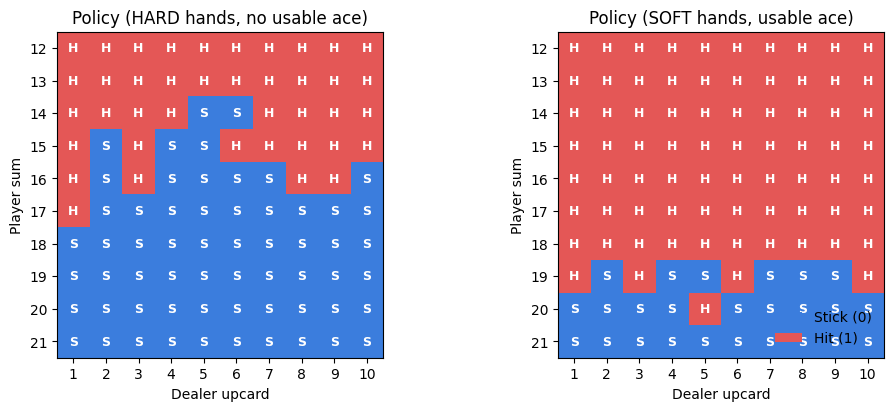

In [209]:
policy = np.argmax(Q, axis=3)
value  = np.max(Q, axis=3)

ps_lo, ps_hi = 12, 22
dc_lo, dc_hi = 1, 11

policy_hard = policy[ps_lo:ps_hi, dc_lo:dc_hi, 0]
policy_soft = policy[ps_lo:ps_hi, dc_lo:dc_hi, 1]

cmap = ListedColormap(["#3b7ddd", "#e45756"])
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

for ax, data, title in zip(
    axes,
    [policy_hard, policy_soft],
    ["Policy (HARD hands, no usable ace)", "Policy (SOFT hands, usable ace)"]
):
    im = ax.imshow(data, cmap=cmap, norm=norm, origin="upper", aspect="equal")
    ax.set_title(title)
    ax.set_xlabel("Dealer upcard")
    ax.set_ylabel("Player sum")

    ax.set_xticks(np.arange(dc_hi - dc_lo))
    ax.set_yticks(np.arange(ps_hi - ps_lo))
    ax.set_xticklabels([str(c) for c in range(dc_lo, dc_hi)])
    ax.set_yticklabels([str(s) for s in range(ps_lo, ps_hi)])

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            txt = "S" if data[i, j] == 0 else "H"
            ax.text(j, i, txt, ha="center", va="center", color="white", fontsize=9, fontweight="bold")

from matplotlib.patches import Patch
legend_elems = [Patch(facecolor="#3b7ddd", label="Stick (0)"),
                Patch(facecolor="#e45756", label="Hit (1)")]
axes[1].legend(handles=legend_elems, loc="lower right", frameon=False)

plt.show()
